In [1]:
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#directories
dataset_dir = 'dataset_cyl'
sift_dir = 'sift'
matches_dir = 'matches'
salient_matches_dir ="salient_matches"
output_dir ="output"

In [3]:
#store the computed images on disk
save_output = False

In [4]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [5]:
class ImageFeature:
    def __init__(self, image, index):
        self.image = image
        self.index = index
    
    def SIFT(self, save_output = False, output_dir = ""):
        sift = cv.SIFT_create()
        self.kp, self.des = sift.detectAndCompute(self.image,None)
        self.img_with_sift=cv.drawKeypoints(self.image,self.kp,self.image)
        if save_output:
            cv.imwrite(os.path.join(output_dir,f"{self.index}.jpg"), self.img_with_sift)

In [6]:
class Match:
    def __init__(self, image_feature_source, image_feature_destination):
        self.image_feature_source = image_feature_source
        self.image_feature_destination = image_feature_destination
    
    def feature_matching(self, threshold, save_output = False, output_dir = ""):
        # FLANN parameters
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks=50)   # or pass empty dictionary
        flann = cv.FlannBasedMatcher(index_params,search_params)
        matches = flann.knnMatch(self.image_feature_source.des,
                                 self.image_feature_destination.des,
                                 k=2)
        # Need to draw only good matches, so create a mask
        self.good = []
        for m,n in matches:
            if m.distance < threshold*n.distance:
                self.good.append((m,n))
        draw_params = dict(matchColor = (0,255,0),
                           singlePointColor = (255,0,0),
                           flags = cv.DrawMatchesFlags_DEFAULT)
        self.img_with_match = cv.drawMatchesKnn(self.image_feature_source.image,
                                                self.image_feature_source.kp,
                                                self.image_feature_destination.image,
                                                self.image_feature_destination.kp,
                                                self.good,None,**draw_params)
        if save_output:
            cv.imwrite(os.path.join(output_dir,f"{self.image_feature_source.index}_{ self.image_feature_destination.index}.jpg"),self.img_with_match)
        
    def check_salient(self, threshold, save_output = False, output_dir = ""):
        if len(self.good) > threshold:
            if save_output:
                cv.imwrite(os.path.join(output_dir,f"{self.image_feature_source.index}_{ self.image_feature_destination.index}.jpg"),self.img_with_match)
            return True
        return False
    
    def fit_homography(self):
        self.src_pts = np.float32([self.image_feature_source.kp[m[0].queryIdx].pt for m in self.good]).reshape(-1,1,2)  
        self.dst_pts = np.float32([self.image_feature_destination.kp[m[0].trainIdx].pt for m in self.good]).reshape(-1,1,2)
        self.M, self.mask = cv.findHomography(self.src_pts, self.dst_pts, cv.RANSAC,5.0)
    
    def normalize_homography(self):
        det = np.linalg.det(self.M)
        self.H = self.M/(det** (1./3.))
        new_det = np.linalg.det(self.H)
    

In [7]:
imgs = load_images_from_folder(dataset_dir)
n = len(imgs)

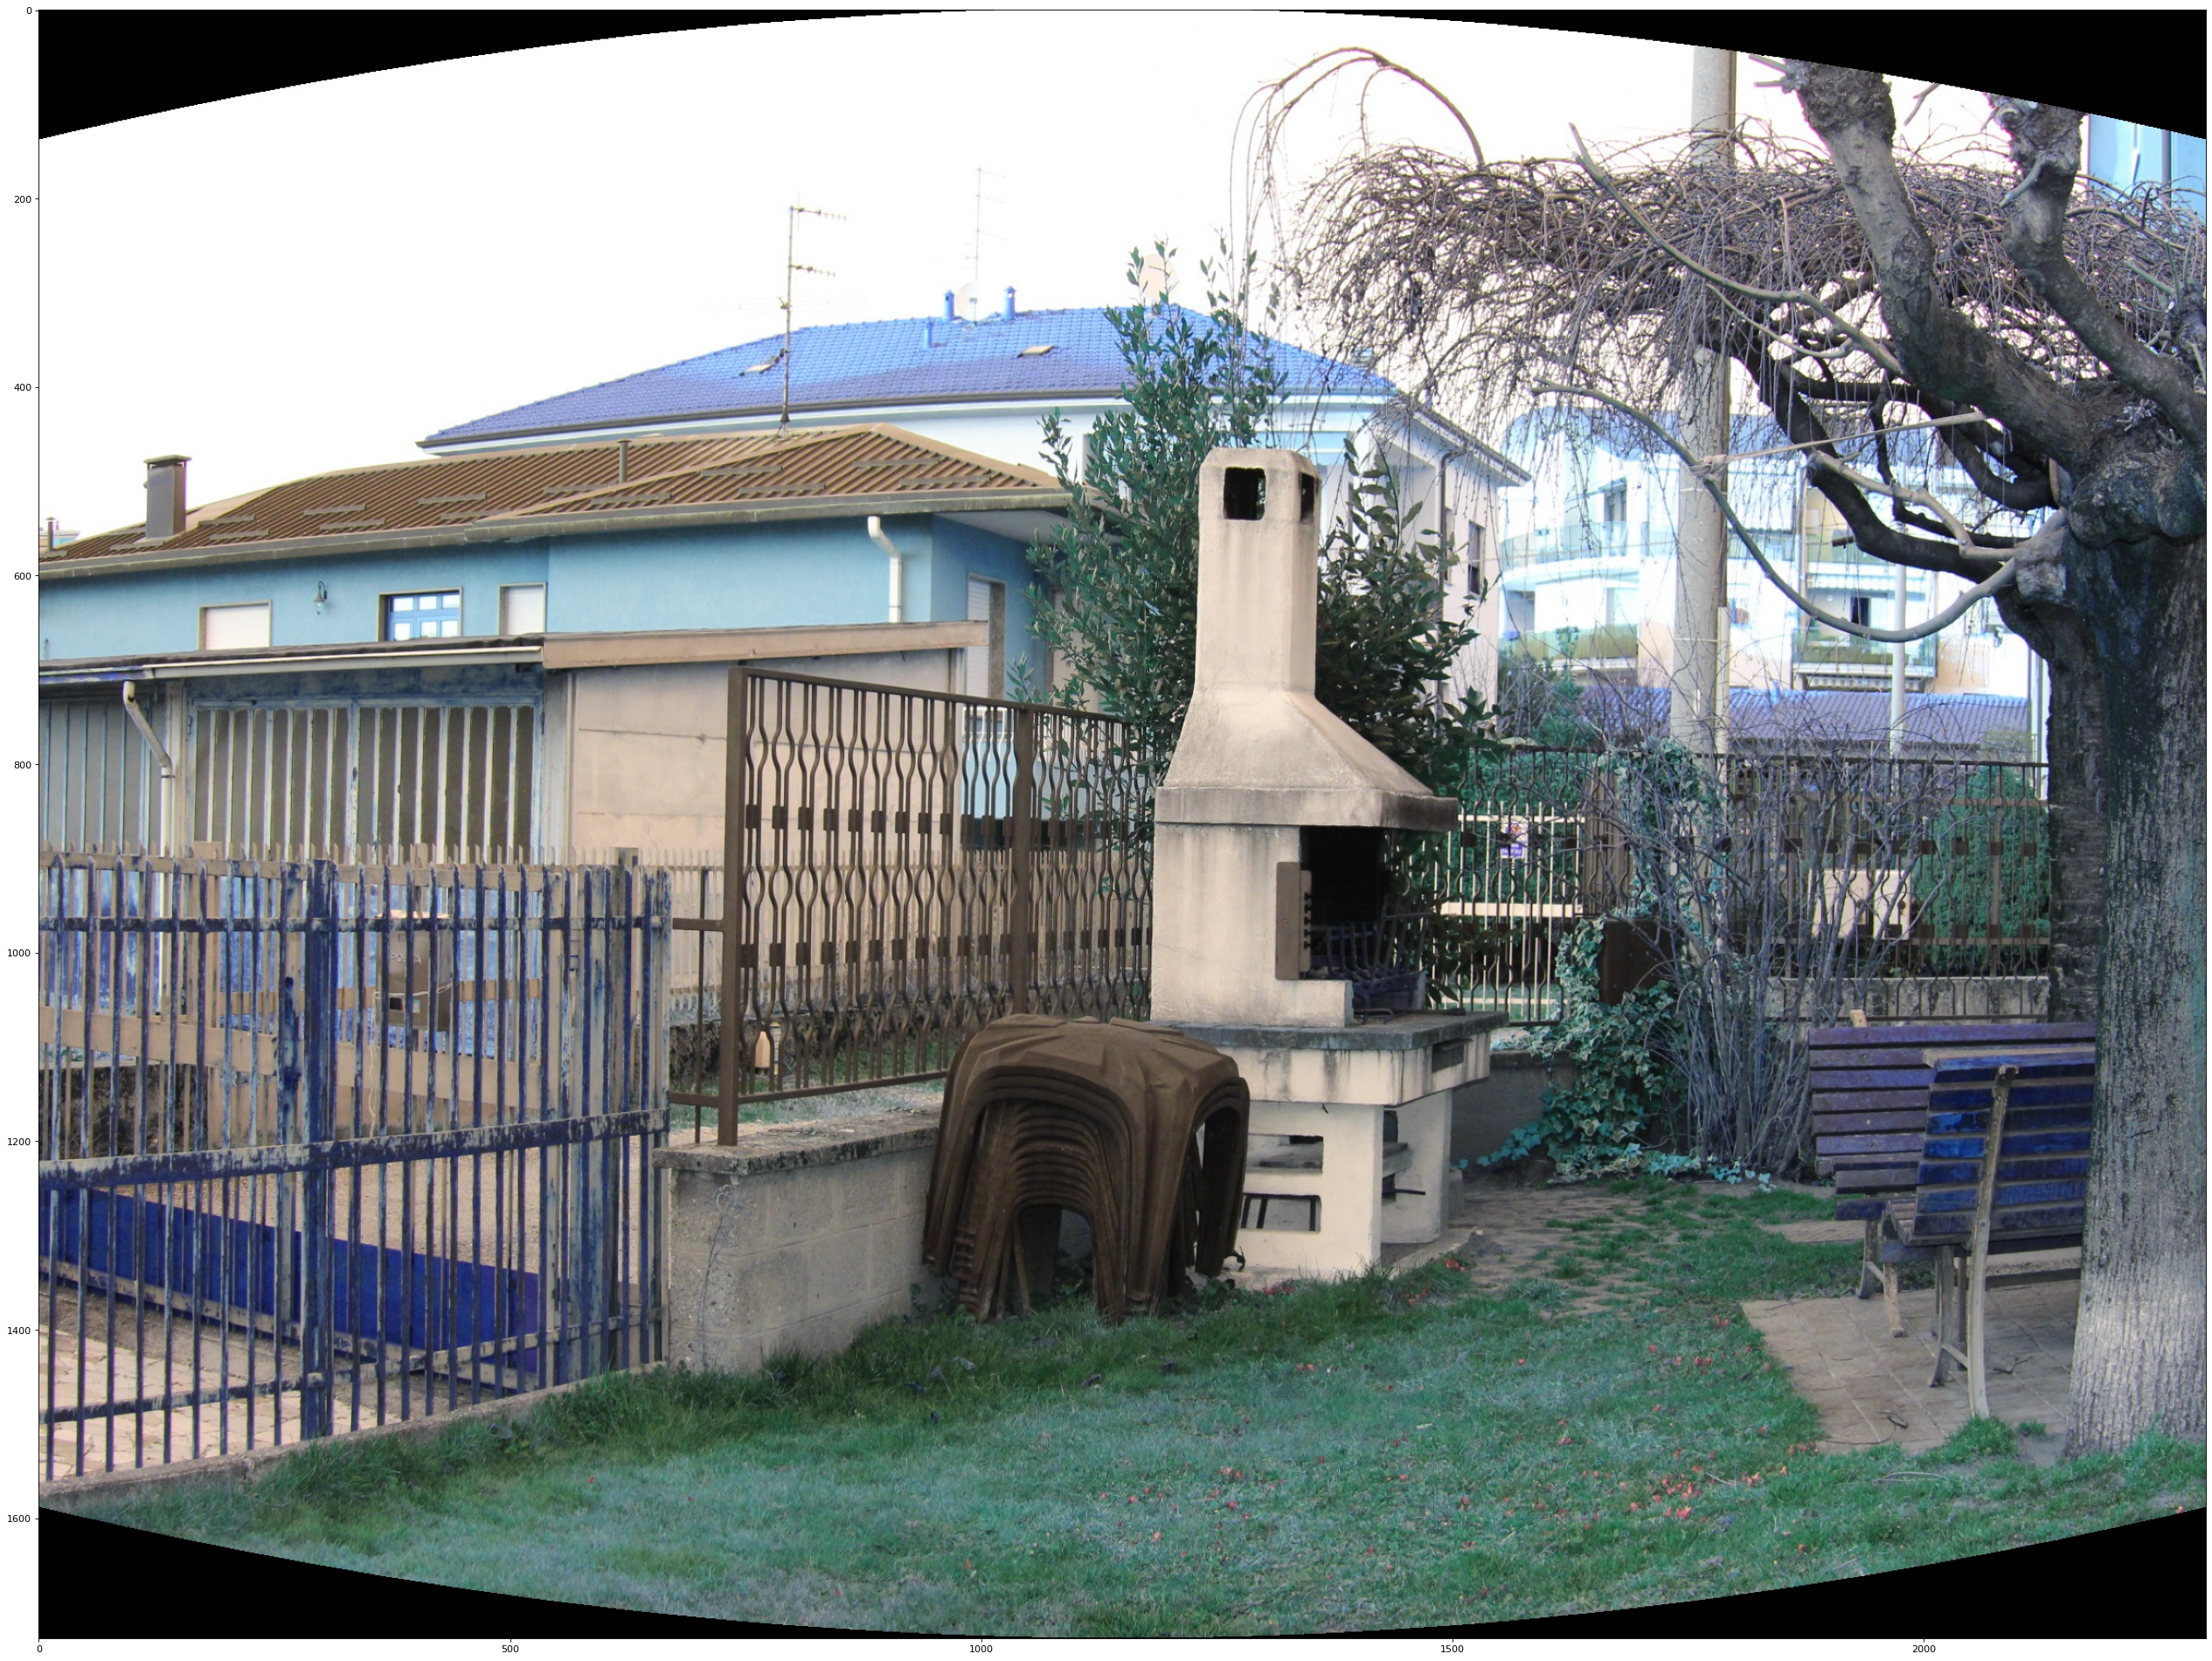

(<matplotlib.image.AxesImage at 0x1f72e4fa5b0>, None)

In [8]:
from matplotlib.pyplot import figure
figure(figsize=(40, 40), dpi=80)
plt.imshow(imgs[0],),plt.show()

In [9]:
image_features =[]
for i in range(0,n):
    image_feature = ImageFeature(imgs[i], i)
    image_feature.SIFT(save_output, sift_dir)
    image_features.append(image_feature)

In [10]:
matches =[]
for i in range(0, n-1):
    for j in range(i+1, n):
        match = Match(image_features[i], image_features[j])
        match.feature_matching(0.6, save_output, matches_dir)
        matches.append(match)


In [11]:
matches_th = 50
salient_matches = list(filter(lambda x: x.check_salient(matches_th, save_output, salient_matches_dir),matches))  
    

In [12]:
total_matches = []
for match in salient_matches:
    inv_match = Match(match.image_feature_destination, match.image_feature_source)
    inv_match.feature_matching(0.6, save_output, matches_dir)
    total_matches.append(match)
    total_matches.append(inv_match)

In [13]:
gamma = np.eye(n,n)
for match in total_matches:
    gamma[match.image_feature_source.index, match.image_feature_destination.index] = 1

In [14]:
zeta = np.sum(gamma, axis=1)

In [15]:
H = np.eye(3*n, 3*n)
for match in total_matches:
    match.fit_homography()
    match.normalize_homography()
    H[3*match.image_feature_source.index:3*(match.image_feature_source.index+1),
      3*match.image_feature_destination.index:3*(match.image_feature_destination.index+1)] = match.H
       

In [16]:
G = np.copy(H)
for i in range(0,n):
    G[3*i:3*(i+1),3*i:3*(i+1)] = np.eye(3,3)*(1-zeta[i])

In [17]:
filename = "G_cyl.npy"
np.save(os.path.join(output_dir,filename), G)

In [18]:
i=0
j=0
print(G[3*i:3*(i+1),3*j:3*(j+1)])

[[-6. -0. -0.]
 [-0. -6. -0.]
 [-0. -0. -6.]]
